In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
import celer
from scipy.ndimage import gaussian_filter
%matplotlib inline

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
import read_and_proc

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
#Function####################################################
import json,pickle
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
        
def do_PCA(var=None,timezoom=None,smooth='Yes',gaussian=0.9,fromcenter='Yes',inradius=None,outradius=None,donormal='Yes',do_PCA='Yes',do_center='Yes'):
    """
    Var: Input variable (must have 4 dimensions! Time-pres-theta-radius)
    """
    if smooth=='Yes':
        from scipy.ndimage import gaussian_filter
        normal_var = []
        if donormal=='Yes':
            for presindex in range(len(var[0,:,0,0])):
                normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'Yes'),sigma=gaussian))
        elif donormal=='No':
            if do_center=='Yes':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','Yes'),sigma=gaussian))
            elif do_center=='No':
                for presindex in range(len(var[0,:,0,0])):
                    normal_var.append(gaussian_filter(normalize_inner(var[:,presindex,:,:],outradius,'No','No'),sigma=gaussian))  
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    else:
        normal_var = []
        for presindex in range(len(var[0,:,0,0])):
            normal_var.append(normalize_inner(var[:,presindex,:,:],outradius))
        normal_var = np.swapaxes(np.asarray(normal_var),0,1)
    if fromcenter=='Yes':
        normal_varf = np.asarray([normal_var[i,:,:,:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])
    elif fromcenter=='No':
        normal_varf = np.asarray([normal_var[i,:,:,inradius:outradius].flatten() \
                                  for i in range(len(normal_var[timezoom[0]:timezoom[1],0,0,0]))])        
    print("--Finish preprocesing--")
    if do_PCA=='Yes':
        from sklearn.decomposition import PCA
        import time
        start_time = time.time()
        skpcaVAR = PCA()
        skpcaVAR.fit(normal_varf.copy())
        print("--- %s seconds ---" % (time.time() - start_time))
        return skpcaVAR,normal_var,normal_varf
    else:
        return normal_var,normal_varf

def normalize_inner(var=None,outerradius=None,standard='Yes',docenter='No'):
    PWper_ctrl = []
    for indx in range(len(var[:,0,0])):
        if docenter=='Yes':
            temp = var[indx,:,:outerradius]-np.nanmean(var[indx,:,:outerradius],axis=(0,1))
        elif docenter=='No':
            temp = var[indx,:,:outerradius]
        if standard=='Yes':
            PWper_ctrl.append((temp-np.nanmean(temp))/np.nanstd(temp))
        elif standard=='No':
            PWper_ctrl.append((temp))
    del temp
    return np.asarray(PWper_ctrl)

def proc_invar_forPCA(var=None,timezoom=None,smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No'):
    return do_PCA(var=var,timezoom=timezoom,smooth='Yes',gaussian=[0,0,0],fromcenter='Yes',inradius=None,outradius=None,donormal='No',doPCA='No')

def flatten(t):
    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
    return [item for sublist in t for item in sublist]
def standardize(t,formula='I'):
    if formula=='I':
        return (t-np.min(np.asarray(t)))/(np.max(np.asarray(t))-np.min(np.asarray(t)))
    elif formula=='II':
        return (t-np.mean(np.asarray(t)))/(np.std(np.asarray(t)))

In [3]:
def prepare_inputdataset(inputTS=None,flat_out=np.zeros((83,12+3+3+9)),lefttimelim=None):
    def flattenlist(inlist=None):
        tempvarlist = []
        for item in inlist:
            tempvarlist.append(item)
        return flatten(tempvarlist)
    input_dataset36 = []
    for timeseries in inputTS:#[pca_timeseries_36,pcaur_timeseries_36,pcavr_timeseries_36,pcaw_timeseries_36]:
        input_dataset36.append(timeseries)
    for i in (range(inputTS[0][:,0].shape[0])):
        tempinlist = [obj[i,:] for obj in input_dataset36]
        flat_out[i,:] = flattenlist(tempinlist)
    return flat_out

def produce_testdataset(TYPE='orig',LT=1,expTYPE='R21'):
    if expTYPE=='R21':
        if TYPE=='TCr':
            output1_TCr = np.concatenate((prepare_inputdataset([forward_diff(pcaur_timeseries,60*60,0,LT),forward_diff(pcavr_timeseries,60*60,0,LT),forward_diff(pcaw_timeseries,60*60,0,LT)],np.zeros((91,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,4+3+9)),ctrl_t2),
                                          prepare_inputdataset([forward_diff(pcaur_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcavr_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,4+3+9)),ctrl_t2)),axis=0)
            return output1_TCr
        elif TYPE=='orig':
            output1_orig = np.concatenate((prepare_inputdataset([forward_diff(pcau_timeseries[5:],60*60,0,LT),forward_diff(pcav_timeseries[5:],60*60,0,LT),forward_diff(pcaw_timeseries[5:],60*60,0,LT)],np.zeros((91,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcav_timeseries_36[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_36[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcav_timeseries_60[60-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_60[60-ctrl_t2:],60*60,0,LT)],np.zeros((59,3+3+9)),ctrl_t2),
                                           prepare_inputdataset([forward_diff(pcau_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcav_timeseries_lwcrf[36-ctrl_t2-5:],60*60,0,LT),forward_diff(pcaw_timeseries_lwcrf[36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2)),axis=0)
            return output1_orig

In [4]:
def output_flatvar_PCAtransform(var=None,ctrlvar=None,needpatch=True,exp=None,timezoom=None,smooth=[3,0,0],inradius=None,outradius=None):
    if needpatch is True:
        patchvar = read_and_proc.add_ctrl_before_senstart(ctrlvar,var,exp,'Yes')
        del var
        _,outflatvarf = do_PCA(var=patchvar,timezoom=timezoom,smooth='Yes',
                               gaussian=smooth,fromcenter='Yes',inradius=inradius,outradius=outradius,donormal='No',doPCA='No')
        return outflatvarf
    else:
        _,outflatvarf = do_PCA(var=var,timezoom=timezoom,smooth='Yes',
                               gaussian=smooth,fromcenter='Yes',inradius=inradius,outradius=outradius,donormal='No',doPCA='No')
        return outflatvarf

def output_PCAtimeseries(PCAdict=None,varname=None,flatvar=None,no_comp=None,standard=True,standardtype='II'):
    if varname is None:
        varname=['dtheta','u','v','w','qv']
    timeseries_out = {}
    for index,var in enumerate(varname):
        if standard is True:
            timeseries_out[var] = standardize(PCA_dict[var].transform(flatvar[index])[:,0:no_comp[index]],standardtype)
        else:
            timeseries_out[var] = PCA_dict[var].transform(flatvar[index])[:,0:no_comp[index]]
    return timeseries_out

def produce_input(PCAtimeseries=None,expname='ncrf36',orig=True,leftstart=None,no_comp=None):
    if no_comp is None:
        no_comp=[12,3,3,9,5]
    if expname=='ctrl':
        if orig is True:
            totltime=91
            dtuvw = prepare_inputdataset([PCAtimeseries['u'][5:],PCAtimeseries['v'][5:],PCAtimeseries['w'][5:],PCAtimeseries['dtheta'][5:]],
                                         np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0])),leftstart)
        uv = prepare_inputdataset([PCAtimeseries['u'][5:],PCAtimeseries['v'][5:]],np.zeros((totltime,no_comp[1]+no_comp[2])),leftstart)
        dtuv = prepare_inputdataset([PCAtimeseries['u'][5:],PCAtimeseries['v'][5:],PCAtimeseries['dtheta'][5:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[0])),leftstart)
        uvw = prepare_inputdataset([PCAtimeseries['u'][5:],PCAtimeseries['v'][5:],PCAtimeseries['w'][5:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3])),leftstart)
        uvwqv = prepare_inputdataset([PCAtimeseries['u'][5:],PCAtimeseries['v'][5:],PCAtimeseries['w'][5:],PCAtimeseries['qv'][5:]],
                                     np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[4])),leftstart)
        uvqv = prepare_inputdataset([PCAtimeseries['u'][5:],PCAtimeseries['v'][5:],PCAtimeseries['qv'][5:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[4])),leftstart)
        dtuvwqv = prepare_inputdataset([PCAtimeseries['u'][5:],PCAtimeseries['v'][5:],PCAtimeseries['w'][5:],PCAtimeseries['dtheta'][5:],PCAtimeseries['qv'][5:]],
                                       np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0]+no_comp[4])),leftstart)
        
        output_dict={'uv':uv,'uvw':uvw,'uvqv':uvqv,'uvwqv':uvwqv,'dtuvw':dtuvw,'dtuvwqv':dtuvwqv,'dtuv':dtuv}
        return output_dict
    else:
        if expname=='ncrf36':
            rsindx,totltime = 36,83
        elif expname=='ncrf60':
            rsindx,totltime = 60,59
        
        if orig is True:
            dtuvw = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart-5:],PCAtimeseries['v'][rsindx-leftstart-5:],
                                          PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0])),leftstart)
            uv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart-5:],PCAtimeseries['v'][rsindx-leftstart-5:]],np.zeros((totltime,no_comp[1]+no_comp[2])),leftstart)
            uvw = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart-5:],PCAtimeseries['v'][rsindx-leftstart-5:],PCAtimeseries['w'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3])),leftstart)
            dtuv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart-5:],PCAtimeseries['v'][rsindx-leftstart-5:],PCAtimeseries['dtheta'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[0])),leftstart)
            uvwqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart-5:],PCAtimeseries['v'][rsindx-leftstart-5:],
                                          PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[4])),leftstart)
            uvqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart-5:],PCAtimeseries['v'][rsindx-leftstart-5:],PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[4])),leftstart)
            dtuvwqv = prepare_inputdataset([PCAtimeseries['u'][rsindx-leftstart-5:],PCAtimeseries['v'][rsindx-leftstart-5:],
                                            PCAtimeseries['w'][rsindx-leftstart:],PCAtimeseries['dtheta'][rsindx-leftstart:],
                                            PCAtimeseries['qv'][rsindx-leftstart:]],np.zeros((totltime,no_comp[1]+no_comp[2]+no_comp[3]+no_comp[0]+no_comp[4])),leftstart)
            output_dict={'uv':uv,'uvw':uvw,'uvqv':uvqv,'uvwqv':uvwqv,'dtuvw':dtuvw,'dtuvwqv':dtuvwqv,'dtuv':dtuv}
            return output_dict

def produce_output_LT(PCAtimeseries=None,expname=['ctrl','ncrf36','ncrf60','lwcrf'],orig=True,leadtime=None):
    def output_timediff(LT=None,inputdict=None,settings=None,exp=None):
        if exp=='ctrl':
            return prepare_inputdataset([forward_diff(inputdict['u'][5:],60*60,0,LT),forward_diff(inputdict['v'][5:],60*60,0,LT),forward_diff(inputdict['w'][5:],60*60,0,LT)],np.zeros((91,3+3+9)),ctrl_t2)
        elif (exp=='ncrf36') or (exp=='lwcrf'):
            return prepare_inputdataset([forward_diff(inputdict['u'][36-ctrl_t2-5:],60*60,0,LT),forward_diff(inputdict['v'][36-ctrl_t2-5:],60*60,0,LT),forward_diff(inputdict['w'][36-ctrl_t2:],60*60,0,LT)],np.zeros((83,3+3+9)),ctrl_t2)
        elif exp=='ncrf60':
            return prepare_inputdataset([forward_diff(inputdict['u'][60-ctrl_t2-5:],60*60,0,LT),forward_diff(inputdict['v'][60-ctrl_t2-5:],60*60,0,LT),forward_diff(inputdict['w'][60-ctrl_t2:],60*60,0,LT)],np.zeros((59,3+3+9)),ctrl_t2)
        
    if orig is True:
        result = []
        for index,expNAME in enumerate(expname):
            result.append(output_timediff(LT=leadtime,inputdict=PCAtimeseries[index],settings=None,exp=expNAME))
        del index,expNAME
        result_con = np.concatenate((result),axis=0)
        return result_con
        
#    produce_testdataset(TYPE='TCr',LT=1,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=2,expTYPE='R21'),produce_testdataset(TYPE='TCr',LT=3,expTYPE='R21')

#### Processed Regression Results

In [5]:
############################################################################################################################################
# PCA_dict: Processed EOF objects; A_dict: Variable anomaly matrices; Af_dict: Flattened variable anomaly matrices
# *note that following EOF conventions, we derived EOFs with anomalies.
############################################################################################################################################
import pickle
path = './output/1010_ns/'
filePCA = [path+'dtheta_pca_ns',path+'urad_pca_ns',path+'vtan_pca_ns',path+'w_pca_ns',path+'qv_pca_ns']
fileAf = [path+'normalT_ctrlf_ns',path+'normalUrad_ctrlf_ns',path+'normalVtan_ctrlf_ns',path+'normalw_ctrlf_ns',path+'normalQV_ctrlf_ns']

outputPCA,outputA,outputAf = [],[],[]
for i in range(len(filePCA)):
    with open(filePCA[i],'rb') as f:
        outputPCA.append(pickle.load(f))
    with open(fileAf[i],'rb') as f:
        outputAf.append(pickle.load(f))

PCA_dict = {'dtheta':outputPCA[0],'u':outputPCA[1],'v':outputPCA[2],'w':outputPCA[3],'qv':outputPCA[4]}
Af_dict = {'dtheta':outputAf[0],'u':outputAf[1],'v':outputAf[2],'w':outputAf[3],'qv':outputAf[4]}

fileA = [path+'normalT_ctrl_ns']
outputA = []
for i in range(len(fileA)):
    with open(fileA[i],'rb') as f:
        outputA.append(pickle.load(f))
A_dict = {'dtheta':outputA[0]}

/work/08350/tg876493/stampede2/gpu_env/fred_workenv/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### Process azimuthal data

In [6]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'

#############################################################
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_W_0-144hr.nc',origin_path+'ctl/azim_QVAPOR_0-144hr.nc',
                                                              origin_path+'ctl/azim_RTHRATLW_0-144hr.nc',origin_path+'ctl/azim_RTHRATSW_0-144hr.nc'],fieldname=['W','QVAPOR','RTHRATLW','RTHRATSW'])
ncrf60var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_60h/azim_W_60-144hr.nc',origin_path+'ncrf_60h/azim_QVAPOR_60-144hr.nc',
                                                                origin_path+'ncrf_60h/azim_RTHRATLW_60-144hr.nc',origin_path+'ncrf_60h/azim_RTHRATSW_60-144hr.nc'],fieldname=['W','QVAPOR','RTHRATLW','RTHRATSW'])
ncrf36var_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ncrf_36h/azim_W_36-144hr.nc',origin_path+'ncrf_36h/azim_QVAPOR_36-144hr.nc',
                                                                origin_path+'ncrf_36h/azim_RTHRATLW_36-144hr.nc',origin_path+'ncrf_36h/azim_RTHRATSW_36-144hr.nc'],fieldname=['W','QVAPOR','RTHRATLW','RTHRATSW'])
lwcrfvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'lwcrf/azim_W_36-144hr.nc',origin_path+'lwcrf/azim_QVAPOR_36-144hr.nc',
                                                               origin_path+'lwcrf/azim_RTHRATLW_36-144hr.nc',origin_path+'lwcrf/azim_RTHRATSW_36-144hr.nc'],fieldname=['W','QVAPOR','RTHRATLW','RTHRATSW'])
################################################################################################################################################################################################################
# (i) Original Heating
#...................................................................................................................................................................................
path = '/work2/08350/tg876493/stampede2/python_codes/tcg_radiation/output/'
file = [path+'ctrl_thetaall',path+'ncrf36_thetaall',path+'ncrf60_thetaall',path+'lwcrf_thetaall']
output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
theta_dict = {'CTRL_theta':output[0],'NCRF36_theta':output[1],'NCRF60_theta':output[2],'LWCRF_theta':output[3]}

# To be consistent with azimuthal files
#.....................................................................................................................................................................................
ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA,lwcrf_thetaA = np.swapaxes(np.asarray(theta_dict['CTRL_theta']),0,1),\
np.swapaxes(np.asarray(theta_dict['NCRF36_theta']),0,1),np.swapaxes(np.asarray(theta_dict['NCRF60_theta']),0,1),np.swapaxes(np.asarray(theta_dict['LWCRF_theta']),0,1)
del output,theta_dict,outputPCA,outputAf
################################################################################################################################################################################################################
# (ii) Radiative and Residual Heating
#...................................................................................................................................................................................
#path = './output/1010_ns/sensitivity/'
#file = [path+'RAD_ctrlf_ns',path+'RAD_ncrf36f_ns',path+'RAD_ncrf60f_ns',path+'RAD_lwcrff_ns',path+'RESI_ctrlf_ns',path+'RESI_ncrf36f_ns',path+'RESI_ncrf60f_ns',path+'RESI_lwcrff_ns']
#output = []
#for i in range(len(file)):
#    with open(file[i],'rb') as f:
#        output.append(pickle.load(f))
#theta_dict = {'CTRL_RADf':output[0],'NCRF36_RADf':output[1],'NCRF60_RADf':output[2],'LWCRF_RADf':output[3],'CTRL_RESIf':output[4],'NCRF36_RESIf':output[5],'NCRF60_RESIf':output[6],'LWCRF_RESIf':output[7]}
#del output

In [ ]:
######################################################################################################################################
# Settings
# (a) Cut off time
#.....................................................................................................................
ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['W']['W'].time/24,1)-1,nearest_index(ctrlvar_dict['W']['W'].time/24,5)-1
# Heating Rate
#.....................................................................................................................
r0,r200=(nearest_index(ctrlvar_dict['W']['W'].radius,0),nearest_index(ctrlvar_dict['W']['W'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['W']['W'].radius,300),nearest_index(ctrlvar_dict['W']['W'].radius,500))
######################################################################################################################################

######################################################################################################################################
# Process variables
#.....................................................................................................................
# (I) W
#.....................................................................................................................
normalWncrf36f,normalWncrf60f,normalWlwcrff = output_flatvar_PCAtransform(ncrf36var_dict['W'].W,ctrlvar_dict['W'].W,True,'NCRF36',[ctrl_t2,ctrl_t4],[3,0,0],None,r500),\
output_flatvar_PCAtransform(ncrf60var_dict['W'].W,ctrlvar_dict['W'].W,True,'NCRF60',[ctrl_t2,ctrl_t4],[3,0,0],None,r500),output_flatvar_PCAtransform(lwcrfvar_dict['W'].W,ctrlvar_dict['W'].W,True,'NCRF36',[ctrl_t2,ctrl_t4],[3,0,0],None,r500)
#.....................................................................................................................
# (II) QV
#.....................................................................................................................
normalQVAPORncrf36f,normalQVAPORncrf60f,normalQVAPORlwcrff = output_flatvar_PCAtransform(ncrf36var_dict['QVAPOR'].QVAPOR,ctrlvar_dict['QVAPOR'].QVAPOR,True,'NCRF36',[ctrl_t2,ctrl_t4],[3,0,0],None,r500),\
output_flatvar_PCAtransform(ncrf60var_dict['QVAPOR'].QVAPOR,ctrlvar_dict['QVAPOR'].QVAPOR,True,'NCRF60',[ctrl_t2,ctrl_t4],[3,0,0],None,r500),output_flatvar_PCAtransform(lwcrfvar_dict['QVAPOR'].QVAPOR,ctrlvar_dict['QVAPOR'].QVAPOR,True,'NCRF36',[ctrl_t2,ctrl_t4],[3,0,0],None,r500)
#.....................................................................................................................
# (III) Heating Rate
#.....................................................................................................................
ncrf36_thetaA_n,ncrf60_thetaA_n,lwcrf_thetaA_n = read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf36_thetaA,'NCRF36','Yes'),\
read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,ncrf60_thetaA,'NCRF60','Yes'),read_and_proc.add_ctrl_before_senstart(ctrl_thetaA,lwcrf_thetaA,'NCRF36','Yes')
ncrf36_thetagrad_b,ncrf60_thetagrad_b,lwcrf_thetagrad_b = forward_diff(gaussian_filter(ncrf36_thetaA_n,sigma=[3,0,0,0]),60*60,0),\
forward_diff(gaussian_filter(ncrf60_thetaA_n,sigma=[3,0,0,0]),60*60,0),forward_diff(gaussian_filter(lwcrf_thetaA_n,sigma=[3,0,0,0]),60*60,0)
normalTncrf36f,normalTncrf60f,normalTlwcrff = output_flatvar_PCAtransform(ncrf36_thetagrad_b,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
output_flatvar_PCAtransform(ncrf60_thetagrad_b,None,False,'NCRF60',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),output_flatvar_PCAtransform(lwcrf_thetagrad_b,None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500)
del ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA,ncrf36var_dict,ncrf60var_dict,lwcrfvar_dict
# (IIIb) Radiative Heating Rate
#.....................................................................................................................
#normalRADctrlf,normalRADncrf36f,normalRADncrf60f,normalRADlwcrff = output_flatvar_PCAtransform(theta_dict['CTRL_RADf'],None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
#output_flatvar_PCAtransform(theta_dict['NCRF36_RADf'],None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),output_flatvar_PCAtransform(theta_dict['NCRF60_RADf'],None,False,'NCRF60',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
#output_flatvar_PCAtransform(theta_dict['LWCRF_RADf'],None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500)
# (IIIc) Residual Heating Rate
#.....................................................................................................................
#normalRESIctrlf,normalRESIncrf36f,normalRESIncrf60f,normalRESIlwcrff = output_flatvar_PCAtransform(theta_dict['CTRL_RESIf'],None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
#output_flatvar_PCAtransform(theta_dict['NCRF36_RESIf'],None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),output_flatvar_PCAtransform(theta_dict['NCRF60_RESIf'],None,False,'NCRF60',[ctrl_t2,ctrl_t4],[0,0,0],None,r500),\
#output_flatvar_PCAtransform(theta_dict['LWCRF_RESIf'],None,False,'NCRF36',[ctrl_t2,ctrl_t4],[0,0,0],None,r500)
#del ctrl_thetaA,ncrf36_thetaA,ncrf60_thetaA,ncrf36var_dict,ncrf60var_dict,lwcrfvar_dict,theta_dict

--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--
--Finish preprocesing--


In [ ]:
#del ncrf36var_dict,ncrf60var_dict,lwcrfvar_dict,theta_dict
path = './output/1010_ns/'
file = [path+'normalUradR_ncrf36f_ns',path+'normalUradR_ncrf60f_ns',path+'normalUradR_lwcrff_ns',path+'normalVtanR_ncrf36f_ns',path+'normalVtanR_ncrf60f_ns',path+'normalVtanR_lwcrff_ns']
file2 = [path+'normalUrad_ncrf36f_ns',path+'normalUrad_ncrf60f_ns',path+'normalUrad_lwcrff_ns',path+'normalVtan_ncrf36f_ns',path+'normalVtan_ncrf60f_ns',path+'normalVtan_lwcrff_ns']
output = []
for i in range(len(file)):
    with open(file[i],'rb') as f:
        output.append(pickle.load(f))
normalUradRncrf36f,normalUradRncrf60f,normalUradRlwcrff = output[0],output[1],output[2]
normalVtanRncrf36f,normalVtanRncrf60f,normalVtanRlwcrff = output[3],output[4],output[5]
del output

output = []
for i in range(len(file2)):
    with open(file2[i],'rb') as f:
        output.append(pickle.load(f))
normalUradncrf36f,normalUradncrf60f,normalUradlwcrff = output[0],output[1],output[2]
normalVtanncrf36f,normalVtanncrf60f,normalVtanlwcrff = output[3],output[4],output[5]

In [ ]:
######################################################################################################################################
# PCA timeseries
#.....................................................................................................................
no_comp = [12,3,3,9,5]
#.....................................................................................................................
ctrl_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[Af_dict['dtheta'],Af_dict['u'],Af_dict['v'],Af_dict['w'],Af_dict['qv']],no_comp=no_comp,standard=True,standardtype='II')
ncrf36_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalTncrf36f,normalUradncrf36f,normalVtanncrf36f,normalWncrf36f,normalWncrf36f],no_comp=no_comp,standard=True,standardtype='II')
ncrf60_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalTncrf60f,normalUradncrf60f,normalVtanncrf60f,normalWncrf60f,normalWncrf60f],no_comp=no_comp,standard=True,standardtype='II')
lwcrf_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalTlwcrff,normalUradlwcrff,normalVtanlwcrff,normalWlwcrff,normalWlwcrff],no_comp=no_comp,standard=True,standardtype='II')
#ctrl_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRADctrlf,Af_dict['u'],Af_dict['v'],Af_dict['w'],Af_dict['qv']],no_comp=no_comp,standard=True,standardtype='II')
#ncrf36_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRADncrf36f,normalUradncrf36f,normalVtanncrf36f,normalWncrf36f,normalWncrf36f],no_comp=no_comp,standard=True,standardtype='II')
#ncrf60_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRADncrf60f,normalUradncrf60f,normalVtanncrf60f,normalWncrf60f,normalWncrf60f],no_comp=no_comp,standard=True,standardtype='II')
#lwcrf_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRADlwcrff,normalUradlwcrff,normalVtanlwcrff,normalWlwcrff,normalWlwcrff],no_comp=no_comp,standard=True,standardtype='II')
#ctrl_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRESIctrlf,Af_dict['u'],Af_dict['v'],Af_dict['w'],Af_dict['qv']],no_comp=no_comp,standard=True,standardtype='II')
#ncrf36_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRESIncrf36f,normalUradncrf36f,normalVtanncrf36f,normalWncrf36f,normalWncrf36f],no_comp=no_comp,standard=True,standardtype='II')
#ncrf60_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRESIncrf60f,normalUradncrf60f,normalVtanncrf60f,normalWncrf60f,normalWncrf60f],no_comp=no_comp,standard=True,standardtype='II')
#lwcrf_PCAtimeseries = output_PCAtimeseries(PCAdict=PCA_dict,varname=['dtheta','u','v','w','qv'],flatvar=[normalRESIlwcrff,normalUradlwcrff,normalVtanlwcrff,normalWlwcrff,normalWlwcrff],no_comp=no_comp,standard=True,standardtype='II')
######################################################################################################################################
# Produce Input
#.....................................................................................................................
CTRLinputdataset_dict = produce_input(ctrl_PCAtimeseries,expname='ctrl',orig=True,leftstart=None,no_comp=[12,3,3,9,5])
NCRF36inputdataset_dict = produce_input(ncrf36_PCAtimeseries,expname='ncrf36',orig=True,leftstart=ctrl_t2,no_comp=[12,3,3,9,5])
NCRF60inputdataset_dict = produce_input(ncrf60_PCAtimeseries,expname='ncrf60',orig=True,leftstart=ctrl_t2,no_comp=[12,3,3,9,5])
LWCRFinputdataset_dict = produce_input(lwcrf_PCAtimeseries,expname='ncrf36',orig=True,leftstart=ctrl_t2,no_comp=[12,3,3,9,5])
#.....................................................................................................................
# Combine experiments
mlr_inputtype = ['uv','uvw','uvqv','dtuv','uvwqv','dtuvw','dtuvwqv']
mlr_inputdict = {}
for TYPE in mlr_inputtype:
    result = np.concatenate([exp[TYPE] for exp in [CTRLinputdataset_dict,NCRF36inputdataset_dict,NCRF60inputdataset_dict,LWCRFinputdataset_dict]],axis=0)
    mlr_inputdict[TYPE] = result
######################################################################################################################################

In [ ]:
######################################################################################################################################
# Make input digestable with our MLR model
#.....................................................................................................................
mlr_inputtype = ['uv','uvw','uvqv','dtuv','uvwqv','dtuvw','dtuvwqv']
mlr_inputdict = {}
for TYPE in mlr_inputtype:
    result = np.concatenate([exp[TYPE] for exp in [CTRLinputdataset_dict,NCRF36inputdataset_dict,NCRF60inputdataset_dict,LWCRFinputdataset_dict]],axis=0)
    mlr_inputdict[TYPE] = result
#.....................................................................................................................
# MLR model output for training
#.....................................................................................................................
LDTME = np.linspace(0,44,45)+1
mlr_output = []
for index,TIMEstamp in enumerate(LDTME):
    mlr_output.append(produce_output_LT([ctrl_PCAtimeseries,ncrf36_PCAtimeseries,ncrf60_PCAtimeseries,lwcrf_PCAtimeseries],['ctrl','ncrf36','ncrf60','lwcrf'],True,leadtime=int(TIMEstamp)))

### Multilinear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import MultiTaskLassoCV
from celer import MultiTaskLassoCV
from celer import Lasso
from sklearn.linear_model import ElasticNet
def produce_regscore(inPUT=None,outPUT=None,aux_inPUT=None,outtype='score',do_aux=False,
                     algorithm='linear',lassoparam=dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),simplassoalpha=0.1):
    if algorithm=='linear':
        reg = LinearRegression().fit(inPUT, outPUT)
    elif algorithm=='lasso':
        #reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
        reg = Lasso(simplassoalpha).fit(inPUT,outPUT)
    elif algorithm=='multilasso':
        reg = MultiTaskLassoCV(**lassoparam).fit(inPUT,outPUT)
    if outtype=='score':
        if do_aux is False:
            return reg.score(inPUT, outPUT)
        elif do_aux is True:
            return reg.score(aux_inPUT,outPUT)
    elif outtype=='predict':
        return reg.predict(inPUT)
    elif outtype=='coeff':
        return reg.coef_
    
def output_regscore(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False):
    if do_aux is False:
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],None,'score',False,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01) for i in range(len(outTS))]
    elif do_aux is True:
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],aux_inTS[:-int(LTlist[i])],'score',True,algorithm,\
                                 dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01) for i in range(len(outTS))]
    
def output_regscore_withmemory(inTS=None,outTS=None,LTlist=None,algorithm='linear',aux_inTS=None,do_aux=False):
    if do_aux is False:
        output = []
        for i in (range(len(outTS))):
            inTRAIN = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inTRAIN,outTRAIN,None,'score',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif do_aux is True:
        output = []
        for i in (range(len(outTS))):
            inTRAIN = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outTRAIN = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            auxin = np.concatenate(((aux_inTS[:-int(LTlist[i])][int(LTlist[i]):]),(aux_inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            output.append(produce_regscore(inTRAIN,outTRAIN,auxin,'score',True,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output        
    
def output_regcoeff(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='with'):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],'coeff',algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01) for i in range(len(outTS))]
    
def output_regpredict(inTS=None,outTS=None,LTlist=None,algorithm='linear',memory='without'):
    if memory=='with':
        output = []
        for i in range(len(outTS)):
            inarray = np.concatenate(((inTS[:-int(LTlist[i])][int(LTlist[i]):]),(inTS[:-int(LTlist[i])][0:-int(LTlist[i])])),axis=1)
            outarray = outTS[i][int(LTlist[i]):-int(LTlist[i])]
            output.append(produce_regscore(inarray,outarray,None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01))
        return output
    elif memory=='without':
        return [produce_regscore(inTS[:-int(LTlist[i])],outTS[i][:-int(LTlist[i])],None,'predict',False,algorithm,dict(tol=1e-6,cv=4,n_jobs=1,n_alphas=20),0.01) for i in range(len(outTS))]

In [ ]:
r2rad_timeseries = []
with open('./output/1010_ns/sensitivity/r2rad_timeseries','rb') as f:
    r2rad_timeseries.append(pickle.load(f))
rad_input = []
with open('./output/1010_ns/sensitivity/r2rad_input','rb') as f:
    rad_input.append(pickle.load(f))
rad_output = []
with open('./output/1010_ns/sensitivity/r2rad_output','rb') as f:
    rad_output.append(pickle.load(f))
    
r2resi_timeseries = []
with open('./output/1010_ns/sensitivity/r2resi_timeseries','rb') as f:
    r2resi_timeseries.append(pickle.load(f))
resi_input = []
with open('./output/1010_ns/sensitivity/r2resi_input','rb') as f:
    resi_input.append(pickle.load(f))
resi_output = []
with open('./output/1010_ns/sensitivity/r2resi_output','rb') as f:
    resi_output.append(pickle.load(f))

In [ ]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v',c='k')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-w')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['dtuv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-dtheta')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uvqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-qv')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['dtuvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='dtheta-u-v-w')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['dtuvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='dtheta-u-v-w-qv')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-w-qv')
axs[0].legend(loc='b')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig',ylim=[0,1])

axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v',c='k')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-w')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['dtuv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-dtheta')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uvqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-qv')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['dtuvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='dtheta-u-v-w')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['dtuvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='dtheta-u-v-w-qv')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear',aux_inTS=None,do_aux=False),label='u-v-w-qv')
axs[1].legend(loc='b')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Memory]',ylim=[0,1])
#plt.savefig('./proc_fig/1122/r2long_orig.png',dpi=400)
plt.show()

In [ ]:
import matplotlib.patheffects as pe
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uv'],mlr_output,LDTME,'linear',rad_input[0]['uv'],True),label='u-v',c='k',lw=1.75,alpha=0.35)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uvw'],mlr_output,LDTME,'linear',rad_input[0]['uvw'],True),label='u-v-w',lw=1.75,alpha=0.35)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['dtuv'],mlr_output,LDTME,'linear',rad_input[0]['dtuv'],True),label='u-v-dtheta',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uvqv'],mlr_output,LDTME,'linear',rad_input[0]['uvqv'],True),label='u-v-qv',lw=1.75,alpha=0.35)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear',rad_input[0]['dtuvw'],True),label='dtheta-u-v-w',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[0].plot(LDTME,output_regscore(mlr_inputdict['dtuvwqv'],mlr_output,LDTME,'linear',rad_input[0]['dtuvwqv'],True),label='dtheta-u-v-w-qv',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uvwqv'],mlr_output,LDTME,'linear',rad_input[0]['uvwqv'],True),label='u-v-w-qv',lw=1.75,alpha=0.35)
axs[0].legend(loc='b')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Radiation]',ylim=[0,1])

axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uv'],mlr_output,LDTME,'linear',rad_input[0]['uv'],True),label='u-v',c='k',lw=1.75,alpha=0.35)
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uvw'],mlr_output,LDTME,'linear',rad_input[0]['uvw'],True),label='u-v-w',lw=1.75,alpha=0.35)
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['dtuv'],mlr_output,LDTME,'linear',rad_input[0]['dtuv'],True),label='u-v-dtheta',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uvqv'],mlr_output,LDTME,'linear',rad_input[0]['uvqv'],True),label='u-v-qv',lw=1.75,alpha=0.35)
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear',rad_input[0]['dtuvw'],True),label='dtheta-u-v-w',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['dtuvwqv'],mlr_output,LDTME,'linear',rad_input[0]['dtuvwqv'],True),label='dtheta-u-v-w-qv',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uvwqv'],mlr_output,LDTME,'linear',rad_input[0]['uvwqv'],True),label='u-v-w-qv',lw=1.75,alpha=0.35)
axs[1].legend(loc='b')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Radiation; Memory]',ylim=[0,1])
plt.savefig('./proc_fig/1122/r2long_rad.png',dpi=400)
plt.show()

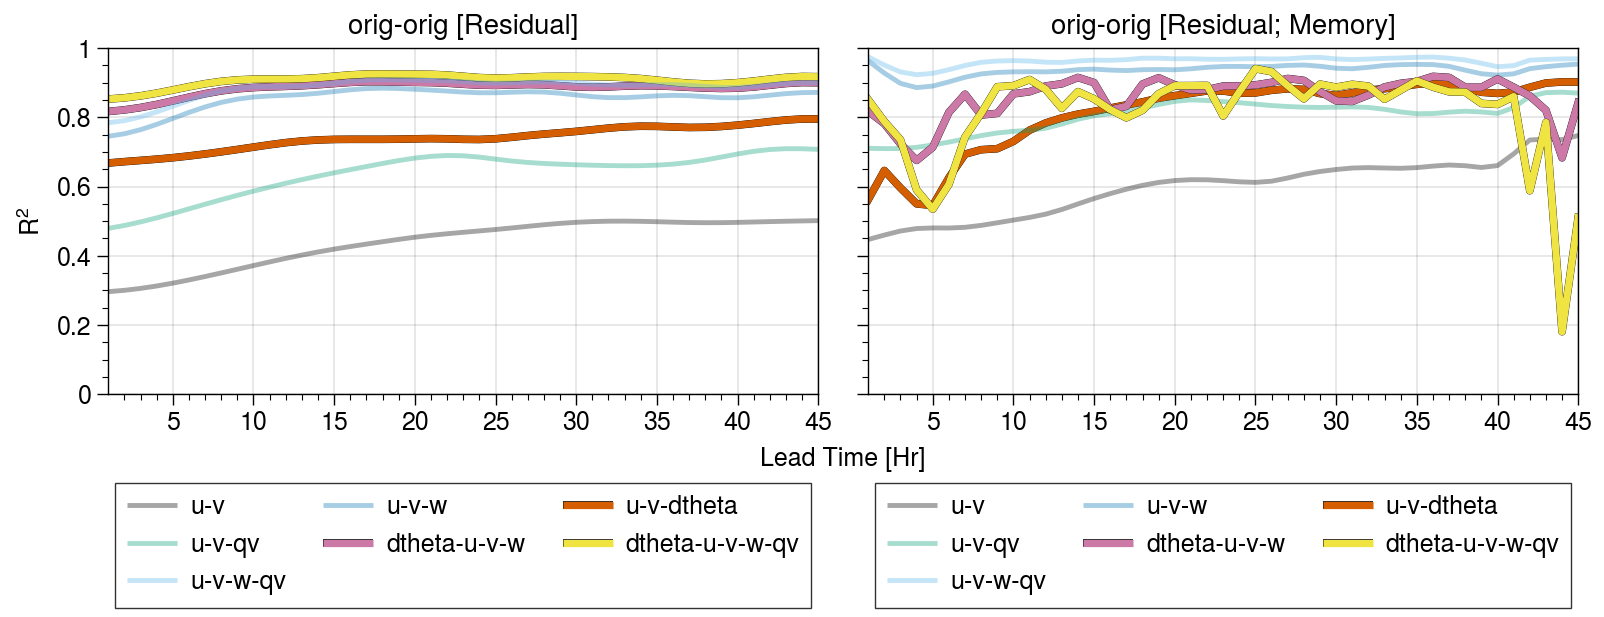

In [34]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uv'],mlr_output,LDTME,'linear',resi_input[0]['uv'],True),label='u-v',c='k',lw=1.75,alpha=0.35)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uvw'],mlr_output,LDTME,'linear',resi_input[0]['uvw'],True),label='u-v-w',lw=1.75,alpha=0.35)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['dtuv'],mlr_output,LDTME,'linear',resi_input[0]['dtuv'],True),label='u-v-dtheta',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uvqv'],mlr_output,LDTME,'linear',resi_input[0]['uvqv'],True),label='u-v-qv',lw=1.75,alpha=0.35)
axs[0].plot(LDTME,output_regscore(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear',resi_input[0]['dtuvw'],True),label='dtheta-u-v-w',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[0].plot(LDTME,output_regscore(mlr_inputdict['dtuvwqv'],mlr_output,LDTME,'linear',resi_input[0]['dtuvwqv'],True),label='dtheta-u-v-w-qv',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[0].plot(LDTME,output_regscore(mlr_inputdict['uvwqv'],mlr_output,LDTME,'linear',resi_input[0]['uvwqv'],True),label='u-v-w-qv',lw=1.75,alpha=0.35)
axs[0].legend(loc='b')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Residual]',ylim=[0,1])

axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uv'],mlr_output,LDTME,'linear',resi_input[0]['uv'],True),label='u-v',c='k',lw=1.75,alpha=0.35)
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uvw'],mlr_output,LDTME,'linear',resi_input[0]['uvw'],True),label='u-v-w',lw=1.75,alpha=0.35)
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['dtuv'],mlr_output,LDTME,'linear',resi_input[0]['dtuv'],True),label='u-v-dtheta',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uvqv'],mlr_output,LDTME,'linear',resi_input[0]['uvqv'],True),label='u-v-qv',lw=1.75,alpha=0.35)
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear',resi_input[0]['dtuvw'],True),label='dtheta-u-v-w',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['dtuvwqv'],mlr_output,LDTME,'linear',resi_input[0]['dtuvwqv'],True),label='dtheta-u-v-w-qv',lw=2.6,
           path_effects=[pe.Stroke(linewidth=2.75, foreground='k'), pe.Normal()])
axs[1].plot(LDTME,output_regscore_withmemory(mlr_inputdict['uvwqv'],mlr_output,LDTME,'linear',resi_input[0]['uvwqv'],True),label='u-v-w-qv',lw=1.75,alpha=0.35)
axs[1].legend(loc='b')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Residual; Memory]',ylim=[0,1])
plt.savefig('./proc_fig/1122/r2long_resi.png',dpi=400)
plt.show()

##### Radiation

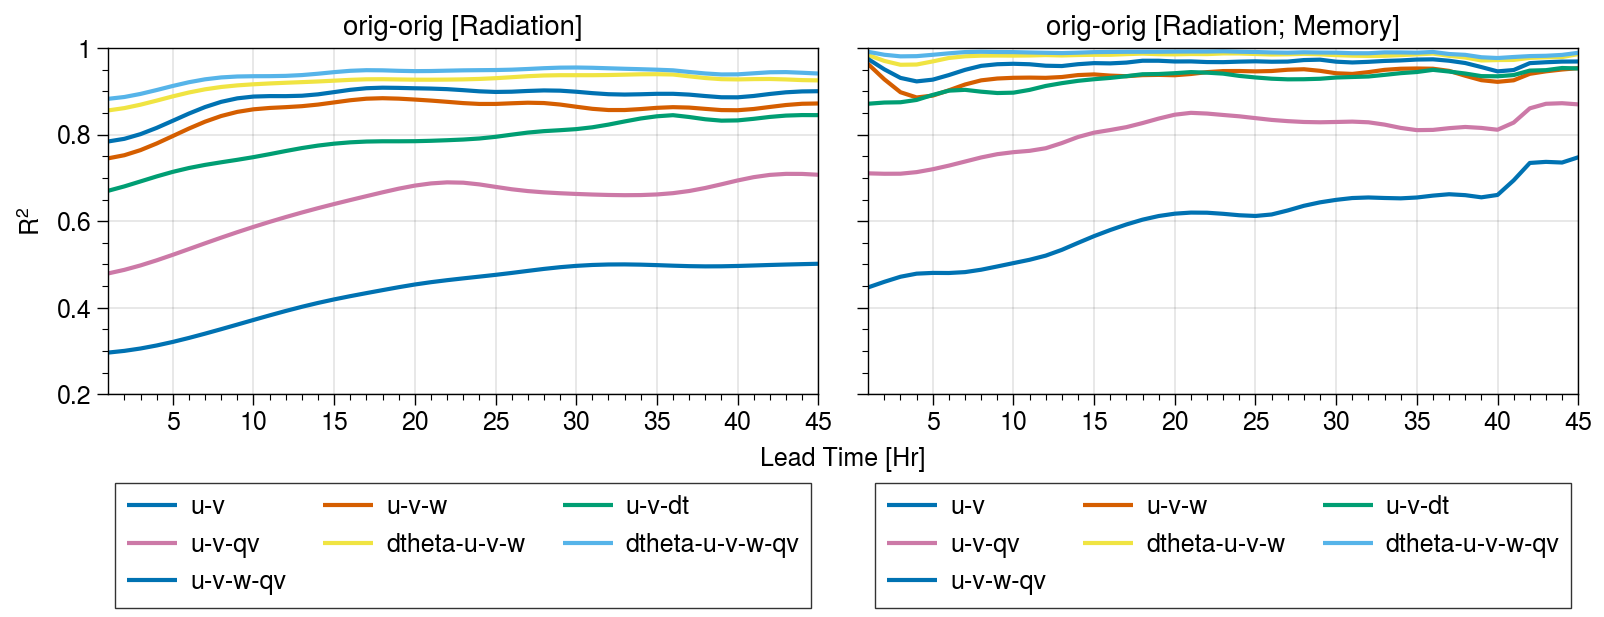

In [24]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.55,refaspect=2.051)
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-w')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['dtuv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-dt')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uvqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-qv')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['dtuvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='dtheta-u-v-w')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['dtuvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='dtheta-u-v-w-qv')
axs[0].plot(LDTME,output_regscore(inTS=mlr_inputdict['uvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-w-qv')
axs[0].legend(loc='b')
axs[0].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Radiation]',ylim=[0.2,1])

axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-w')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['dtuv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-dt')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uvqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-qv')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['dtuvw'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='dtheta-u-v-w')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['dtuvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='dtheta-u-v-w-qv')
axs[1].plot(LDTME,output_regscore_withmemory(inTS=mlr_inputdict['uvwqv'],outTS=mlr_output,LTlist=LDTME,algorithm='linear'),label='u-v-w-qv')
axs[1].legend(loc='b')
axs[1].format(ylabel='R$^2$',xlabel='Lead Time [Hr]',title='orig-orig [Radiation; Memory]',ylim=[0.2,1])
plt.show()

In [14]:
#mlr_inputtype = ['uv','uvw','uvqv','dtuv','uvwqv','dtuvw','dtuvwqv']
r2rad_inputdict = {}
for TYPE in mlr_inputtype:
    result = output_regscore(inTS=mlr_inputdict[TYPE],outTS=mlr_output,LTlist=LDTME,algorithm='linear')
    r2rad_inputdict[TYPE] = result

def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None
save_to_pickle('./output/1010_ns/sensitivity/r2resi_timeseries',r2rad_inputdict)
save_to_pickle('./output/1010_ns/sensitivity/r2resi_input',mlr_inputdict)
save_to_pickle('./output/1010_ns/sensitivity/r2resi_output',mlr_output)

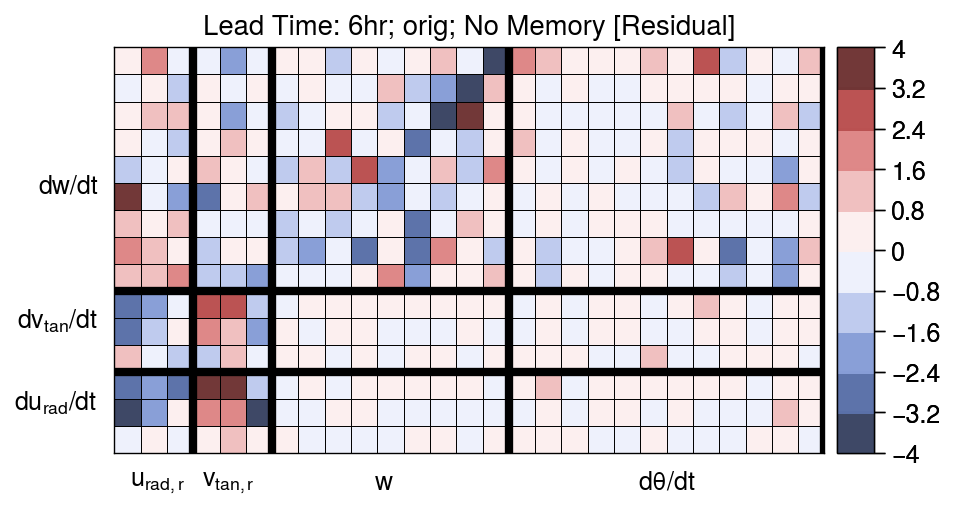

In [15]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.55,refaspect=1.751,share=False)
leadtimec = 6
cout=axs[0].pcolormesh(LinearRegression().fit(mlr_inputdict['dtuvw'][:-int(leadtimec)], 
                                              mlr_output[5][:-int(leadtimec)]).coef_/1e-5,cmap='Div',cmap_kw={'cut': -0.01},
                       vmin=-4,vmax=4,edgecolors='k', linewidths=0.25,alpha=0.99, shading='auto')
axs[0].colorbar(cout,loc='r')
axs[0].format(xticks=[1.15,3.85,9.75,20.5],xticklabels=['u$_{rad,r}$','v$_{tan,r}$','w',r'd$\theta$/dt'],yticks=[1.5,4.5,9.5],
              yticklabels=['du$_{rad}$/dt','dv$_{tan}$/dt','dw/dt'],title='Lead Time: 6hr; orig; No Memory [Residual]')
axs[0].tick_params(axis='y',which='both',left=False)
axs[0].tick_params(axis='x',which='both',bottom=False)
for i in [3-0.5,6-0.5,15-0.5,15-0.5+12]:
    axs[0].axvline(i,lw=3,color='k')
for i in [3-0.5,6-0.5]:
    axs[0].axhline(i,lw=3,color='k')
plt.savefig('./proc_fig/1122/uvwt_lt6_nm_coeff_resiheat.png',dpi=400)
plt.show()

In [27]:
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

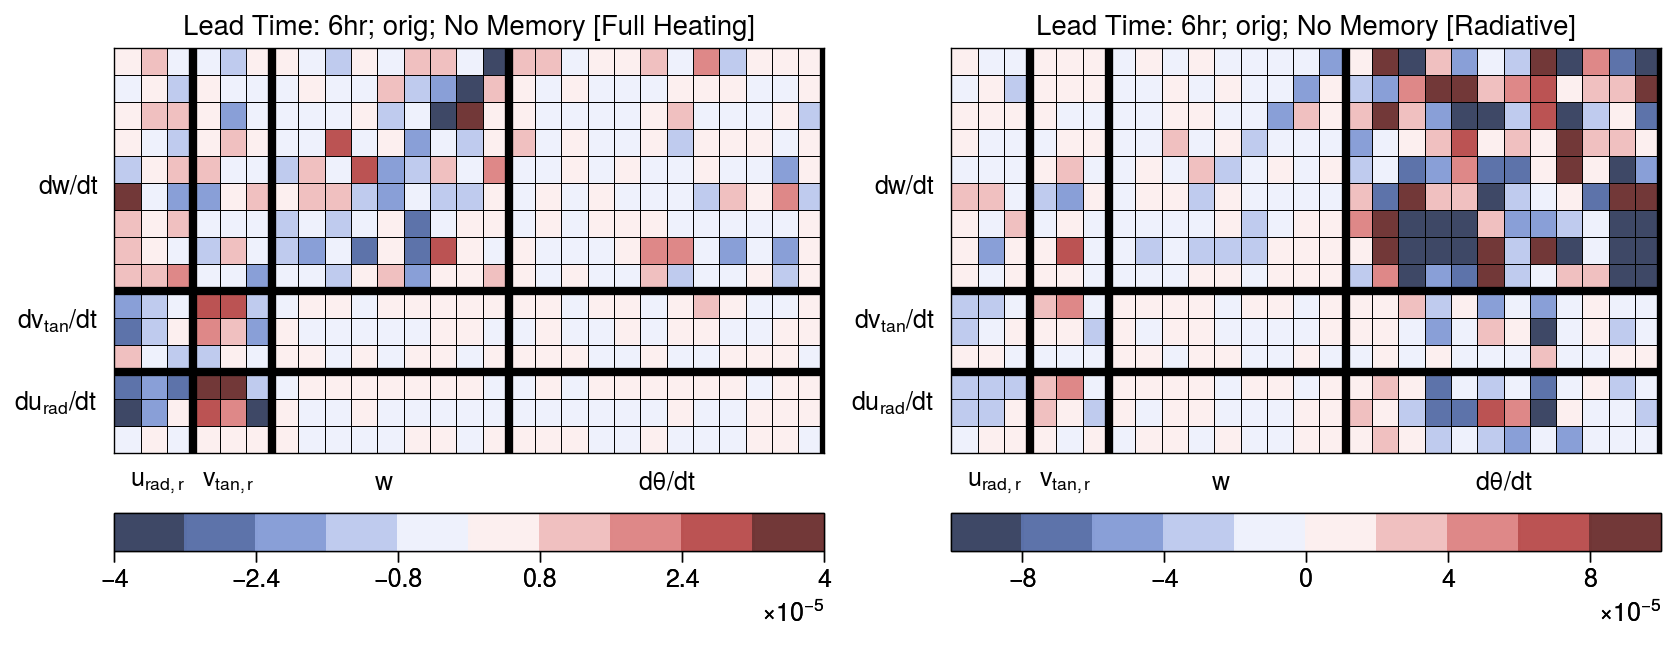

In [29]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.55,refaspect=1.751,share=False)
leadtimec = 6
cout=axs[0].pcolormesh(LinearRegression().fit(mlr_inputdict['dtuvw'][:-int(leadtimec)], 
                                              mlr_output[int(leadtimec)-1][:-int(leadtimec)]).coef_,cmap='Div',cmap_kw={'cut': -0.01},
                       vmin=-4e-5,vmax=4e-5,edgecolors='k', linewidths=0.25,alpha=0.99, shading='auto')
cbar = axs[0].colorbar(cout,loc='b',format=ticker.FuncFormatter(fmt))
#cbar.formatter.set_powerlimits((0, 0))
axs[0].format(xticks=[1.15,3.85,9.75,20.5],xticklabels=['u$_{rad,r}$','v$_{tan,r}$','w',r'd$\theta$/dt'],yticks=[1.5,4.5,9.5],
              yticklabels=['du$_{rad}$/dt','dv$_{tan}$/dt','dw/dt'],title='Lead Time: 6hr; orig; No Memory [Full Heating]')
axs[0].tick_params(axis='y',which='both',left=False)
axs[0].tick_params(axis='x',which='both',bottom=False)
for i in [3-0.5,6-0.5,15-0.5,15-0.5+12]:
    axs[0].axvline(i,lw=3,color='k')
for i in [3-0.5,6-0.5]:
    axs[0].axhline(i,lw=3,color='k')

cout=axs[1].pcolormesh(LinearRegression().fit(rad_input[0]['dtuvw'][:-int(leadtimec)], 
                                              rad_output[0][int(leadtimec)-1][:-int(leadtimec)]).coef_,cmap='Div',cmap_kw={'cut': -0.01},
                       vmin=-10e-5,vmax=10e-5,edgecolors='k', linewidths=0.25,alpha=0.99, shading='auto')
cbar2 = axs[1].colorbar(cout,loc='b',ticks=[-8e-5,-4e-5,0,4e-5,8e-5],format=ticker.FuncFormatter(fmt))
#cbar2.formatter.set_powerlimits((0, 0))
axs[1].format(xticks=[1.15,3.85,9.75,20.5],xticklabels=['u$_{rad,r}$','v$_{tan,r}$','w',r'd$\theta$/dt'],yticks=[1.5,4.5,9.5],
              yticklabels=['du$_{rad}$/dt','dv$_{tan}$/dt','dw/dt'],title='Lead Time: 6hr; orig; No Memory [Radiative]')
axs[1].tick_params(axis='y',which='both',left=False)
axs[1].tick_params(axis='x',which='both',bottom=False)
for i in [3-0.5,6-0.5,15-0.5,15-0.5+12]:
    axs[1].axvline(i,lw=3,color='k')
for i in [3-0.5,6-0.5]:
    axs[1].axhline(i,lw=3,color='k')
plt.savefig('./proc_fig/1122/uvwt_lt6_nm_coeff_fullheatradheat.png',dpi=400)
plt.show()

### Reconstruction

In [ ]:
fileA = [path+'normalT_ctrl_ns']
outputA = []
for i in range(len(fileA)):
    with open(fileA[i],'rb') as f:
        outputA.append(pickle.load(f))
A_dict = {'dtheta':outputA[0]}

In [ ]:
test[:91,6:]

In [23]:
#91,83,59,83
test = output_regpredict(mlr_inputdict['dtuvw'],mlr_output,LDTME,'linear','without')[6]

In [45]:
testrec_dudt = np.dot(test[:91,0:3],(PCA_dict['u'].components_[0:3])).reshape((91,39,360,167))
testrec_dvdt = np.dot(test[:91,3:6],(PCA_dict['v'].components_[0:3])).reshape((91,39,360,167))
testrec_dwdt = np.dot(test[:91,6:],(PCA_dict['w'].components_[0:9]))#.reshape((39,360,167))
testrec_dwdt#+=np.nanmean(Af_dict['w'],axis=0)
Test_recon = testrec_dwdt.reshape((91,39,360,167))

In [51]:
np.nanmean(Af_dict['w'][5:],axis=(0,1))

5.2438127e-11

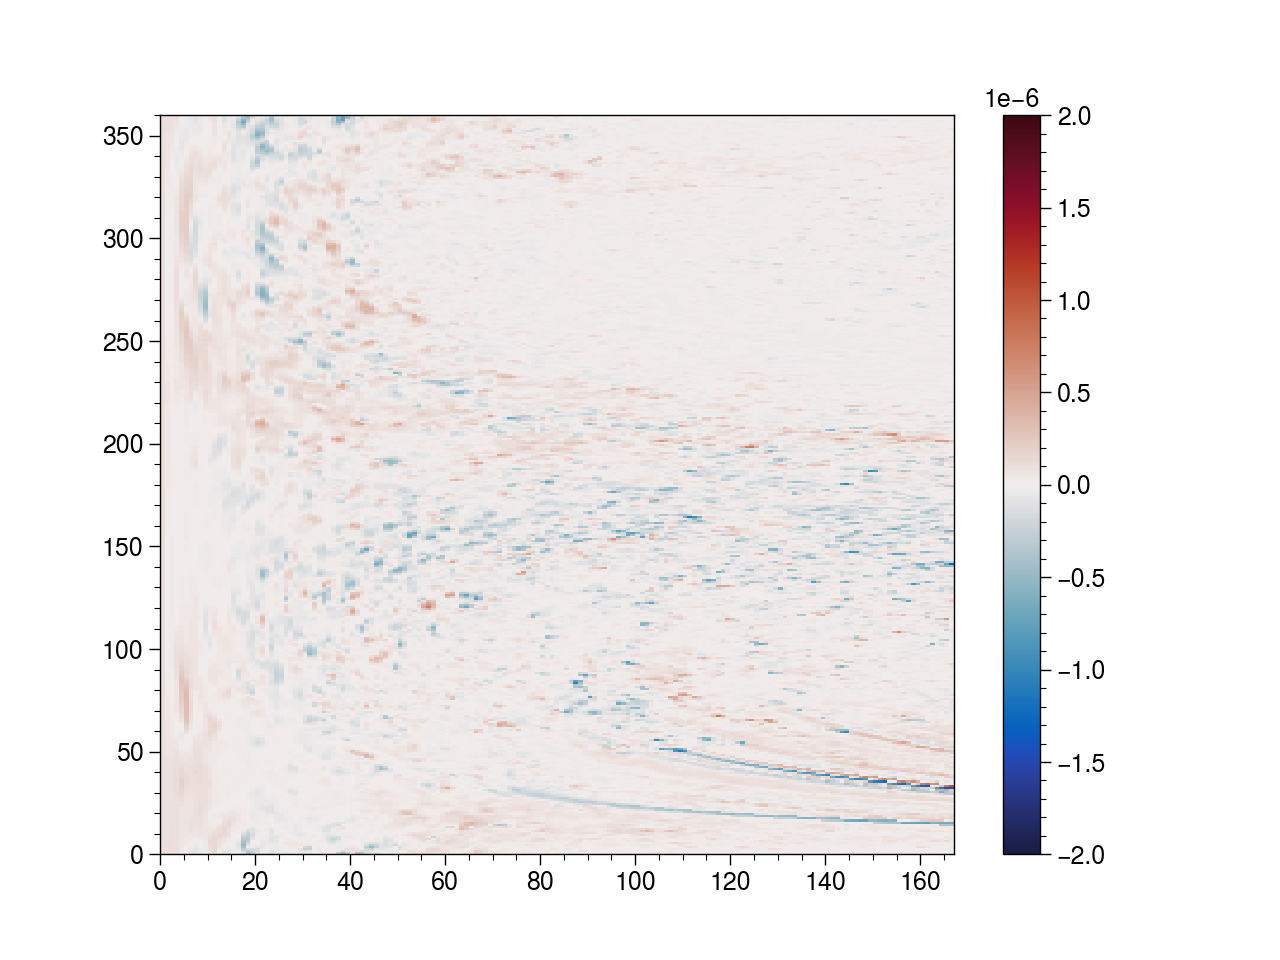

In [54]:
plt.pcolormesh(Test_recon[11][22,:,:],vmin=-2e-6,vmax=2e-6,cmap='balance')#+np.nanmean(ctrlvar_dict['W']['W'][ctrl_t2+5:ctrl_t4,:,:,:r500],axis=(0,1)))
plt.colorbar()
plt.show()

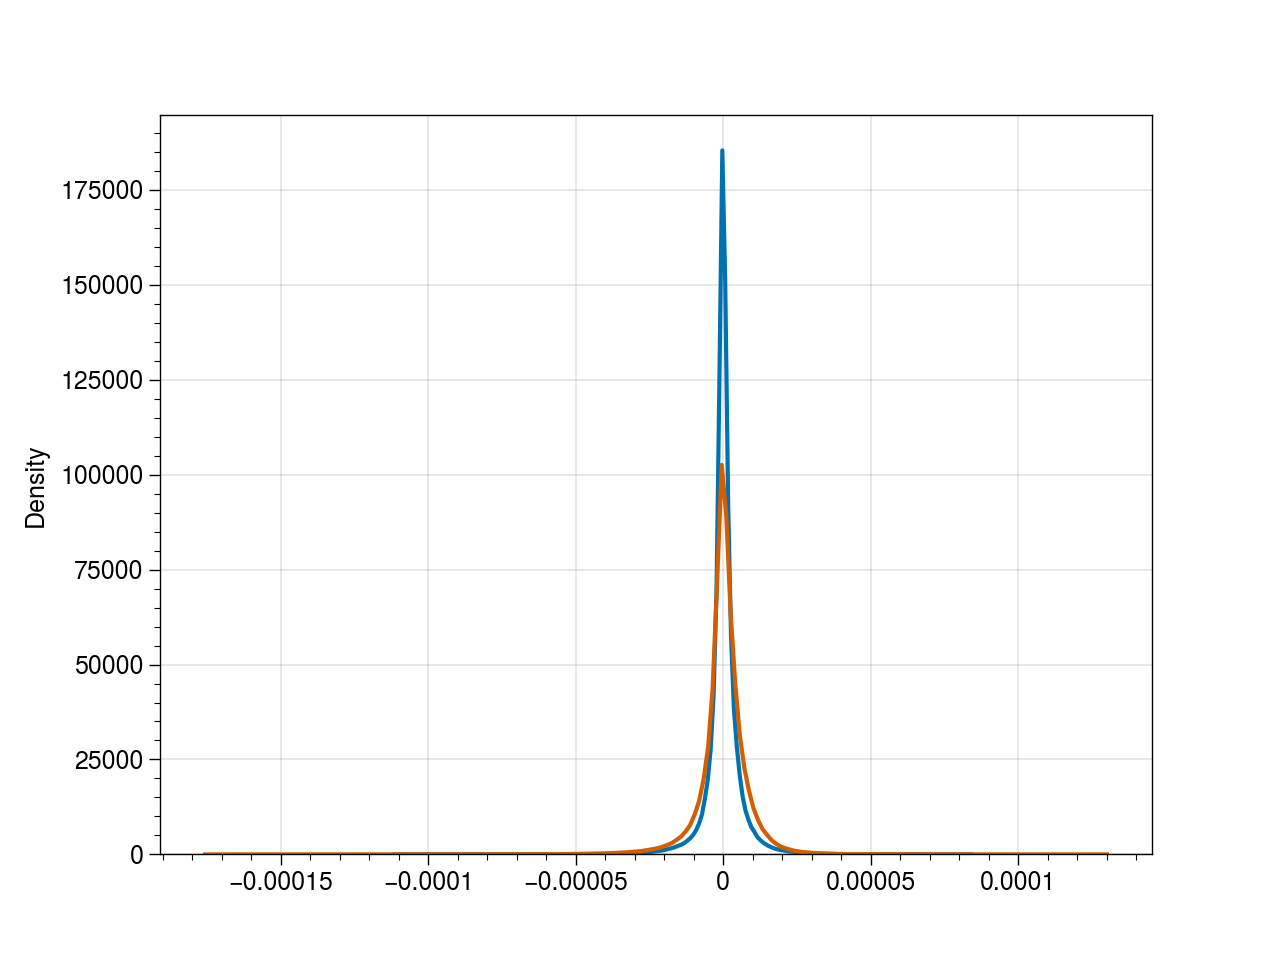

In [31]:
sns.kdeplot(toplot.flatten())
sns.kdeplot(Test_recon[11].flatten()*100)
plt.show()

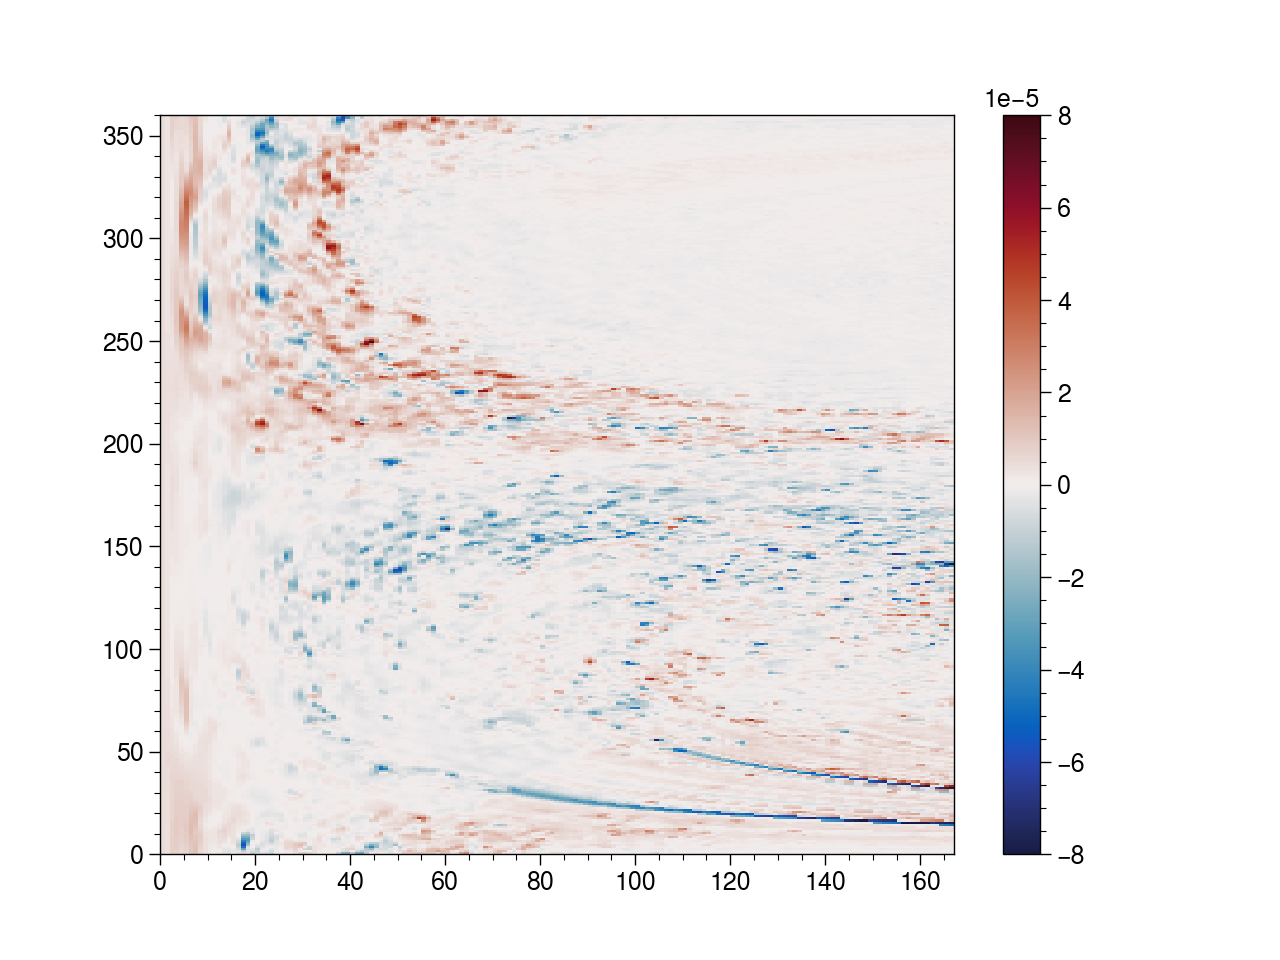

In [52]:
toplot = forward_diff(Af_dict['w'],60*60,0,6)[5:][11].reshape((39,360,167))
plt.pcolormesh(toplot[22,:,:],vmin=-8e-5,vmax=8e-5,cmap='balance')
plt.colorbar()
plt.show()

In [34]:
import scipy
def azimuth2angle(azimuth=None):
    """
    https://math.stackexchange.com/questions/926226/conversion-from-azimuth-to-counterclockwise-angle
    """
    angletest = 450-azimuth
    for index,item in enumerate(angletest):
        if item>360:
            angletest[index] = item-360
        else:
            continue
    return angletest

def closest_index(array=None,target=None):
    return np.abs(array-target).argmin()

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""

    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))

    return (r,theta_index)

def proc_tocart(polarfield=None,angle=None,twoD=True,twoDlv=None,standard=False):
    if twoD==False:
        PWnew = [np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0] * 2,PWnew.shape[0] * 2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))
    elif twoD==True:
        PWnew = [np.asarray(polarfield)[int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0] * 2,PWnew.shape[0] * 2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))

In [26]:
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_W_0-144hr.nc'],fieldname=['W'])
############################################################################################################################################
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-ctrlvar_dict['W'].radius[:r500]),ctrlvar_dict['W'].radius[:r500][:]))
del ctrlvar_dict